In [3]:
import pandas as pd

In [4]:
df=pd.read_csv("btc_1m_data.csv")
df

,timestamp,open,high,low,close,vol
0,2025-02-18 06:36:00,95331.8,95332.6,95294.1,95301.6,5.079237
1,2025-02-18 06:37:00,95301.6,95326.4,95271.3,95319.9,3.267250
2,2025-02-18 06:38:00,95319.9,95332.7,95303.9,95304.0,0.676588
3,2025-02-18 06:39:00,95308.8,95308.8,95261.7,95285.9,11.140823
4,2025-02-18 06:40:00,95285.9,95300.0,95256.3,95299.9,3.533684
...,...,...,...,...,...,...
1435,2025-02-19 06:31:00,95378.7,95383.4,95358.0,95378.4,0.924602
1436,2025-02-19 06:32:00,95378.6,95388.3,95374.0,95388.3,0.323909
1437,2025-02-19 06:33:00,95388.2,95388.3,95386.6,95388.1,0.066854
1438,2025-02-19 06:34:00,95388.2,95390.1,95379.9,95379.9,0.289172


01:51:27 - cmdstanpy - INFO - Chain [1] start processing
01:51:28 - cmdstanpy - INFO - Chain [1] done processing


Test MAE: 250.7267


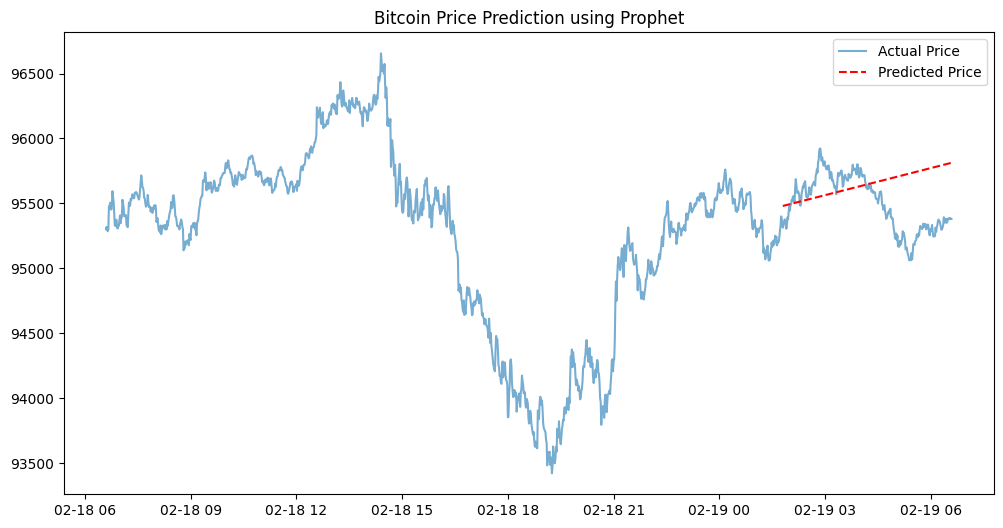

In [8]:
import pandas as pd
from prophet import Prophet
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt

# 1️⃣ Load Data
df = pd.read_csv("btc_1m_data.csv", parse_dates=["timestamp"])

# 2️⃣ Preprocess Data
df_prophet = df[["timestamp", "close"]].rename(columns={"timestamp": "ds", "close": "y"})

# 3️⃣ Split Train and Test Data
train_size = int(len(df_prophet) * 0.8)  # 80% train, 20% test
train = df_prophet[:train_size]
test = df_prophet[train_size:]

# 4️⃣ Train Prophet Model
model = Prophet()
model.fit(train)

# 5️⃣ Predict Future Data
future = model.make_future_dataframe(periods=len(test), freq="min")  # in minutes
forecast = model.predict(future)

# 6️⃣ Compute Test Error
test_forecast = forecast.iloc[train_size:][["ds", "yhat"]]  # Extract yhat
mae = mean_absolute_error(test["y"], test_forecast["yhat"])
print(f"Test MAE: {mae:.4f}")

# 7️⃣ Visualization
plt.figure(figsize=(12, 6))
plt.plot(df_prophet["ds"], df_prophet["y"], label="Actual Price", alpha=0.6)
plt.plot(test_forecast["ds"], test_forecast["yhat"], label="Predicted Price", color="red", linestyle="dashed")
plt.legend()
plt.title("Bitcoin Price Prediction using Prophet")
plt.show()

Test MAE: 13.5266


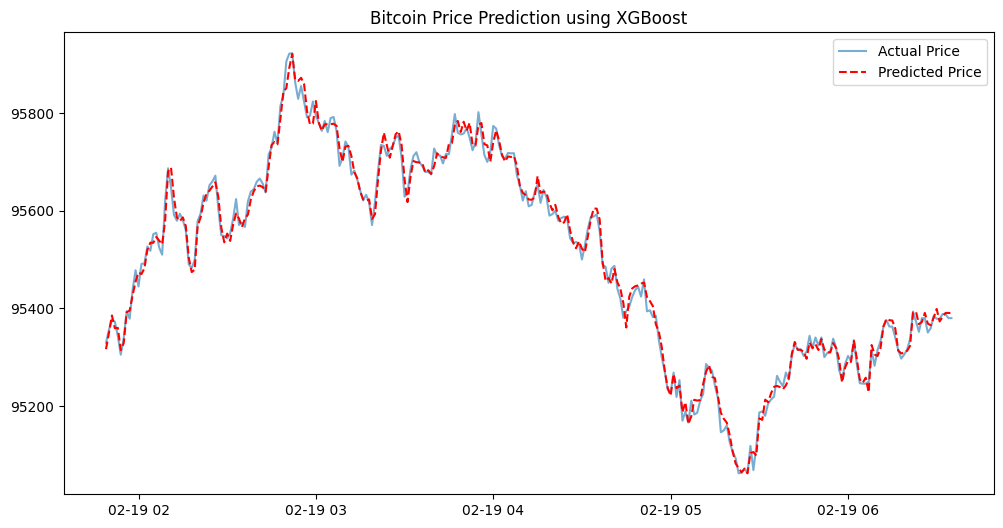

In [12]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt

# 1️⃣ Load Data
df = pd.read_csv("btc_1m_data.csv", parse_dates=["timestamp"])
df.set_index("timestamp", inplace=True)

# 2️⃣ Feature Engineering
# Creating lag features (previous values of close price)
for lag in range(1, 6):  # Using past 5 minutes as features
    df[f"close_lag_{lag}"] = df["close"].shift(lag)

df.dropna(inplace=True)  # Remove rows with NaN values

# 3️⃣ Define Features and Target
features = ["open", "high", "low", "vol"] + [f"close_lag_{lag}" for lag in range(1, 6)]
target = "close"

X = df[features]
y = df[target]

# 4️⃣ Split Train and Test Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# 5️⃣ Train XGBoost Model
model = xgb.XGBRegressor(objective="reg:squarederror", n_estimators=100, learning_rate=0.1, max_depth=5)
model.fit(X_train, y_train)

# 6️⃣ Make Predictions
y_pred = model.predict(X_test)

# 7️⃣ Compute Test Error
mae = mean_absolute_error(y_test, y_pred)
print(f"Test MAE: {mae:.4f}")

# 8️⃣ Visualization
plt.figure(figsize=(12, 6))
plt.plot(y_test.index, y_test, label="Actual Price", alpha=0.6)
plt.plot(y_test.index, y_pred, label="Predicted Price", color="red", linestyle="dashed")
plt.legend()
plt.title("Bitcoin Price Prediction using XGBoost")
plt.show()

In [ ]:
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

# 1️⃣ 读取数据
df = pd.read_csv("btc_1m_data.csv", parse_dates=["timestamp"])
df.set_index("timestamp", inplace=True)

# 2️⃣ 计算波动率
volatility_window = 5
df["window_high"] = df["high"].rolling(window=volatility_window).max()
df["window_low"] = df["low"].rolling(window=volatility_window).min()
df["window_open"] = df["open"].shift(volatility_window - 1)
df["volatility"] = (df["window_high"] - df["window_low"]) / df["window_open"]

# 3️⃣ 计算均线
ma_window = 5
df["ma"] = df["close"].rolling(window=ma_window).mean()

# 4️⃣ 生成交易信号
volatility_threshold = 0.005
df["raw_buy"] = (df["volatility"] >= volatility_threshold) & (df["close"] < df["ma"])
df["raw_sell"] = (df["volatility"] >= volatility_threshold) & (df["close"] > df["ma"])
df["open_signal"] = 0
df.loc[(df["raw_buy"]) & (~df["raw_buy"].shift(1).fillna(False)), "open_signal"] = 1
df.loc[(df["raw_sell"]) & (~df["raw_sell"].shift(1).fillna(False)), "open_signal"] = -1

# 5️⃣ 创建滑动窗口特征（过去 10 根 K 线）
train_window = 10
for lag in range(1, train_window + 1):
    df[f"close_lag_{lag}"] = df["close"].shift(lag)

df.dropna(inplace=True)

# 6️⃣ 选择特征和目标
features = ["open", "high", "low", "volatility"] + [f"close_lag_{lag}" for lag in range(1, train_window + 1)]
X = df[features]

# **使用整数标签代替独热编码**
df["open_signal_encoded"] = df["open_signal"] + 1  # 变为 [0, 1, 2]
y = df["open_signal_encoded"]  # 用单列整数作为 y

# 7️⃣ 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# 8️⃣ 训练 XGBoost 多分类模型
model = xgb.XGBClassifier(objective="multi:softmax", num_class=3, n_estimators=100, learning_rate=0.1, max_depth=5)
model.fit(X_train, y_train)

# 9️⃣ 预测
y_pred = model.predict(X_test)

# 🔟 转换回 `[-1, 0, 1]`
y_pred = y_pred - 1
y_test_labels = y_test - 1  # 真实标签转换回 `[-1, 0, 1]`

# 1️⃣1️⃣ 计算准确率
accuracy = accuracy_score(y_test_labels, y_pred)
print(f"✅ XGBoost 交易信号预测准确率: {accuracy:.4f}")

# 1️⃣2️⃣ 分类报告
print("📊 分类报告:")
print(classification_report(y_test_labels, y_pred))

# 1️⃣3️⃣ 交易信号可视化
plt.figure(figsize=(12, 5))
plt.plot(y_test.index, y_test_labels, label="Actual Signal", alpha=0.7)
plt.plot(y_test.index, y_pred, label="Predicted Signal", linestyle="dashed", color="red")
plt.legend()
plt.title("Actual vs Predicted Trading Signals (Fixed Integer Labels)")
plt.show()


✅ XGBoost 交易信号预测准确率: 0.0000
📊 分类报告:
              precision    recall  f1-score   support

          -2       0.00      0.00      0.00       3.0
          -1       0.00      0.00      0.00    1424.0
           0       0.00      0.00      0.00       3.0
           1       0.00      0.00      0.00       0.0

    accuracy                           0.00    1430.0
   macro avg       0.00      0.00      0.00    1430.0
weighted avg       0.00      0.00      0.00    1430.0



C:\Users\36679\AppData\Local\Temp\ipykernel_43604\1152236740.py:28: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.loc[(df["raw_buy"]) & (~df["raw_buy"].shift(1).fillna(False)), "open_signal"] = 1
C:\Users\36679\AppData\Local\Temp\ipykernel_43604\1152236740.py:29: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.loc[(df["raw_sell"]) & (~df["raw_sell"].shift(1).fillna(False)), "open_signal"] = -1
c:\Users\36679\Downloads\daima\COIN\coin\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being 

AttributeError: 'numpy.ndarray' object has no attribute 'index'

<Figure size 1200x500 with 0 Axes>

✅ XGBoost 在完整数据集上的预测准确率: 1.0000
📊 分类报告:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       1.00      1.00      1.00      1424
           2       1.00      1.00      1.00         3

    accuracy                           1.00      1430
   macro avg       1.00      1.00      1.00      1430
weighted avg       1.00      1.00      1.00      1430



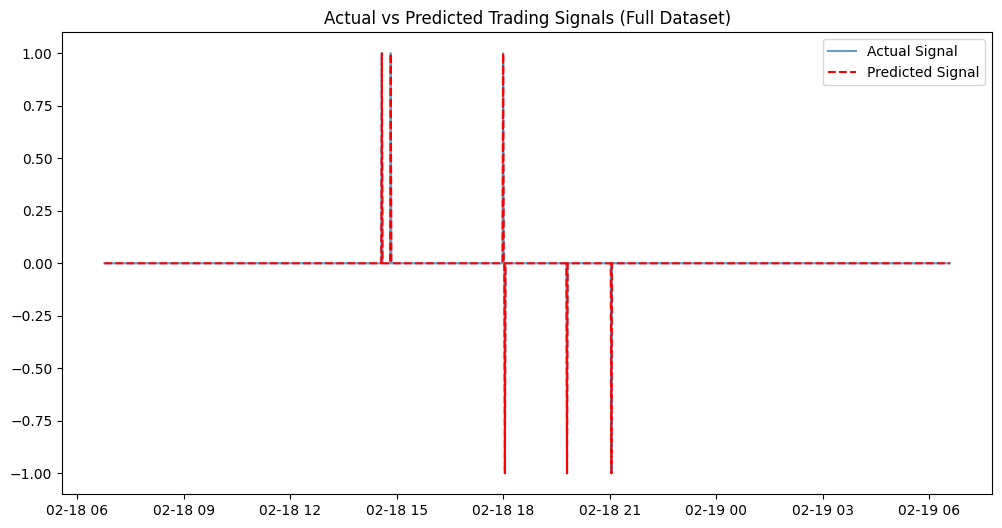

In [21]:
# 9️⃣ 在完整数据集上预测
df["predicted_signal"] = model.predict(X) - 1  # 还原回 [-1, 0, 1]

# 🔟 计算准确率
accuracy = accuracy_score(df["open_signal"] + 1, df["predicted_signal"] + 1)
print(f"✅ XGBoost 在完整数据集上的预测准确率: {accuracy:.4f}")

# 1️⃣1️⃣ 分类报告
print("📊 分类报告:")
print(classification_report(df["open_signal"] + 1, df["predicted_signal"] + 1))

# 1️⃣2️⃣ 可视化
plt.figure(figsize=(12, 6))
plt.plot(df.index, df["open_signal"], label="Actual Signal", alpha=0.7)
plt.plot(df.index, df["predicted_signal"], label="Predicted Signal", linestyle="dashed", color="red")
plt.legend()
plt.title("Actual vs Predicted Trading Signals (Full Dataset)")
plt.show()